In [2]:
import xarray as xr
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import glob
import scipy.stats
import airfuse.util

In [3]:
#generate stats table
def get_stats(data, pollutant):
    NMB_all = list()
    NME_all = list()
    FB_all = list()
    FE_all = list()
    r2_all = list()
    site_ID_all = list()
    lat_all = list()
    lon_all = list()
    grp_data = data.groupby('SiteId')

    for site, subdata in grp_data:
        subdata = subdata[subdata['{}_ob'.format(pollutant)] != -999]
        if (len(subdata['{}_ob'.format(pollutant)]) > 0 and sum(subdata['{}_ob'.format(pollutant)]) != 0):
            NMB = np.sum(subdata['{}_mod'.format(pollutant)] - subdata['{}_ob'.format(pollutant)]) / np.sum(subdata['{}_ob'.format(pollutant)])
            NME = np.sum(np.abs(subdata['{}_mod'.format(pollutant)] - subdata['{}_ob'.format(pollutant)])) / np.sum(subdata['{}_ob'.format(pollutant)])
            sum_model_minus_observed = np.sum(subdata['{}_mod'.format(pollutant)] - subdata['{}_ob'.format(pollutant)])
            sum_abs_model_minus_observed = np.sum(np.abs(subdata['{}_mod'.format(pollutant)] - subdata['{}_ob'.format(pollutant)]))
            sum_model_plus_observed_divided_2 = np.sum((subdata['{}_mod'.format(pollutant)] + subdata['{}_ob'.format(pollutant)])/2)
            FB = sum_model_minus_observed / sum_model_plus_observed_divided_2
            FE = sum_abs_model_minus_observed / sum_model_plus_observed_divided_2
            r2_obs = subdata[~((subdata['{}_ob'.format(pollutant)].isnull()) | (subdata['{}_mod'.format(pollutant)].isnull()))]['{}_ob'.format(pollutant)]
            r2_mod = subdata[~((subdata['{}_ob'.format(pollutant)].isnull()) | (subdata['{}_mod'.format(pollutant)].isnull()))]['{}_mod'.format(pollutant)]
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r2_obs, r2_mod)
            r2 = r_value ** 2
            NMB_all.append(NMB)
            FB_all.append(FB)
            FE_all.append(FE)
            NME_all.append(NME)
            r2_all.append(r2)
            site_ID_all.append(site)
            lat_all.append(subdata['Latitude'].iloc[0])
            lon_all.append(subdata['Longitude'].iloc[0])
    stat_table = pd.DataFrame({'AQS_ID': site_ID_all, 'lat': lat_all, 'lon': lon_all, 'NMB': NMB_all, 'NME': NME_all,
                               'FB': FB_all, 'FE': FE_all, 'r2': r2_all})
    stat_table.sort_values(by='AQS_ID', inplace=True)
    stat_table = stat_table[['AQS_ID', 'lat', 'lon', 'NMB', 'NME', 'FB', 'FE', 'r2']]
    return stat_table

In [4]:
#soccer plot
def plotsoccer_(x,y):
    plt.plot([-x, -x],[0, y],'--k')
    plt.plot([-x, x],[y, y],'--k')
    plt.plot([x, x],[0, y],'--k')

def plotsoccer(Stat_table, pollutant, year):
    fig, ax = plt.subplots(figsize=(12, 9))
    h_all=list()
    for i in range(0, len(Stat_table)):
        h, = plt.plot(Stat_table['FB'].iloc[i]*100, Stat_table['FE'].iloc[i]*100,
                      'ok', markerfacecolor='grey',
                      markersize=10)
        #plt.text(Stat_table['FB'].iloc[i]*100, Stat_table['FE'].iloc[i]*100 - 0.05, Stat_table['Site_name'].iloc[i])
        h_all.append(h)
    #plt.legend(handles=h_all,loc='best',numpoints=1)
    #plt.legend(handles=h_all, numpoints=1, loc='best')
    x_all = [15, 30, 60]
    y_all = [35, 50, 75]
    for x,  y in zip(x_all,  y_all):
        plotsoccer_(x, y)
    plt.xticks([-60,  -30,  -15,  0,  15,  30,  60],  ['-60',  '-30',  '-15',  '0',  '15',  '30',  '60'],  fontsize=15)
    #plt.xticks([-100, -50, 0, 50, 100], ['-100', '-50', '0', '50', '100'], fontsize=15)
    plt.xlabel('Fractional Bias (%)',  fontsize=20)
    plt.ylabel('Fractional Error (%)',  fontsize=20)
    plt.yticks([35,  50,  75], ['35',  '50',  '75'],  fontsize=15)
    plt.xlim(-120,  120)
    plt.ylim(0,  120)
    plt.title('{0} fire season {1} for California'.format(year,  pollutant),  fontsize=20)
#title need to be re-desgin



In [4]:
#scatter for all sites
def plotscatter(data, pollutant, year, unit, output_dir):
    grouped_data = data.groupby(['SiteId'])
    for name, gr in grouped_data:
        print('working on site {}'.format(name))
        fig, ax = plt.subplots(figsize=(12, 9))
        maxaxis = np.nanmax(gr[['{}_mod'.format(pollutant), '{}_ob'.format(pollutant)]].values)
        plt.plot(gr['{}_ob'.format(pollutant)],  gr['{}_mod'.format(pollutant)],  'ok',
                 markerfacecolor='grey',  markersize=15)
        plt.plot([0, maxaxis], [0,  maxaxis], '-k')
        plt.plot([0, maxaxis], [0,  maxaxis/2], '-k')
        plt.plot([0, maxaxis/2], [0,  maxaxis], '-k')
        plt.xlabel('{}_ob ({})'.format(pollutant, unit), fontsize=20)
        plt.ylabel('{}_mod ({})'.format(pollutant, unit), fontsize=20)
        sitename = name
        plt.title('{0} {1} {2}'.format(year, sitename, pollutant), fontsize=20)
        out_file_name = os.path.join(output_dir, '{}_{}_{}_{}_scatter.png'.format(year, name, pollutant, site))
        plt.savefig(out_file_name, bbox_inches='tight')
        plt.close()

In [31]:
def densityplot(data,pollutant,unit,statsdf):
    nmon = data['SiteId'].unique().size
    n = TAQS.shape[0]
    xy = np.vstack([data['{}_ob'.format(pollutant)],data['{}_mod'.format(pollutant)]])
    z = scipy.stats.gaussian_kde(xy)(xy)
    fig, ax = plt.subplots()
    p = ax.scatter(TAQS['{}_ob'.format(pollutant)], TAQS['{}_mod'.format(pollutant)], c=z, s=100)
    ax.legend(*p.legend_elements(), loc="center left", bbox_to_anchor=(1, .5),title="density")
    ax.text(0-2.5, 32.5, 'y={slope:.2f}x+{intercept:.1f} (r={r:.2f})\nmb={mb:.1f};nmb={nmb:.1f}%;\nnme={nme:.1f}%'.format(**statsdf['{}_mod'.format(pollutant)]))
    ax.axline((0, 0), slope=1, color='k', linestyle='--')
    plt.xlabel("Observed " + pollutant + " ("  + unit + ")",  fontsize=12)
    plt.ylabel("Modeled " + pollutant + " ("  + unit + ")",  fontsize=12)
    ax.set(aspect=1, ylim=(-5, 40), xlim=(-5, 40), title=f'number of obs={n}; number of site={nmon}')
#think about to include date range and location, such as state, county etc

In [37]:
#stat map
def stat_map(data,stat_var):
    import pycno
    ax = stat_data.reset_index().plot.scatter(
    x='lon', y='lat', c=stat_var, vmin=-1, vmax=1, cmap='seismic')
    pycno.cno().drawstates()
    ax.set(facecolor='gainsboro')
#title and other information

In [6]:
site = 'AQS'
#aqs_O3_daily_path = f'/work/ROMO/SiteComp/CMAQ/2022hc_cb6r5ae7_HEMI/36US3.v2/AQS_Daily/AQS_Daily_O3'
aqs_daily_path = f'/work/ROMO/SiteComp/CMAQ/2022hc_cb6r5ae7_HEMI/36US3.v2/AQS_Daily'
project_dir = r"/work/ROMO/users/jhuang/2022Modeling_Platform_v1/data/2022_modeling_platform/python_code"
output_dir = os.path.join(project_dir, 'model_performance_evaluation')
output_table_dir = os.path.join(output_dir, site, 'stat_talbe')
output_fig_soccer_dir = os.path.join(output_dir, site, 'soccer_plot')
output_fig_scatter_dir = os.path.join(output_dir, site, 'scatter_plot')
output_fig_timeseries_dir = os.path.join(output_dir, site, 'timseries_plot')
os.makedirs(output_table_dir, exist_ok=True)
os.makedirs(output_fig_soccer_dir, exist_ok=True)
os.makedirs(output_fig_scatter_dir, exist_ok=True)
os.makedirs(output_fig_timeseries_dir, exist_ok=True)
months = pd.Series(np.arange(1,13,1))

In [7]:
for month in months:
#month = 1
    if month < 10:
        month = "0"+ str(month)
    else:
        month = str(month)
    tmp_file = os.path.join(aqs_daily_path, f'AQS_Daily.CMAQ_2022hc_cb6r5ae7_HEMI_36US3.2022'+month+'.csv')
    print("reading" + tmp_file)
    tmp_data = pd.read_csv(tmp_file,skiprows = 5)
    if month == "01":
        AQS_data = tmp_data
    else:
        AQS_data = pd.concat([AQS_data,tmp_data])

reading/work/ROMO/SiteComp/CMAQ/2022hc_cb6r5ae7_HEMI/36US3.v2/AQS_Daily/AQS_Daily.CMAQ_2022hc_cb6r5ae7_HEMI_36US3.202201.csv
reading/work/ROMO/SiteComp/CMAQ/2022hc_cb6r5ae7_HEMI/36US3.v2/AQS_Daily/AQS_Daily.CMAQ_2022hc_cb6r5ae7_HEMI_36US3.202202.csv
reading/work/ROMO/SiteComp/CMAQ/2022hc_cb6r5ae7_HEMI/36US3.v2/AQS_Daily/AQS_Daily.CMAQ_2022hc_cb6r5ae7_HEMI_36US3.202203.csv
reading/work/ROMO/SiteComp/CMAQ/2022hc_cb6r5ae7_HEMI/36US3.v2/AQS_Daily/AQS_Daily.CMAQ_2022hc_cb6r5ae7_HEMI_36US3.202204.csv
reading/work/ROMO/SiteComp/CMAQ/2022hc_cb6r5ae7_HEMI/36US3.v2/AQS_Daily/AQS_Daily.CMAQ_2022hc_cb6r5ae7_HEMI_36US3.202205.csv
reading/work/ROMO/SiteComp/CMAQ/2022hc_cb6r5ae7_HEMI/36US3.v2/AQS_Daily/AQS_Daily.CMAQ_2022hc_cb6r5ae7_HEMI_36US3.202206.csv
reading/work/ROMO/SiteComp/CMAQ/2022hc_cb6r5ae7_HEMI/36US3.v2/AQS_Daily/AQS_Daily.CMAQ_2022hc_cb6r5ae7_HEMI_36US3.202207.csv
reading/work/ROMO/SiteComp/CMAQ/2022hc_cb6r5ae7_HEMI/36US3.v2/AQS_Daily/AQS_Daily.CMAQ_2022hc_cb6r5ae7_HEMI_36US3.202208.csv


# Done with data reading
## starting stats calculation

In [12]:
#data filter for each polllutant

In [8]:
year = 2022
pollutant = "PM_TOT"
AQS_data_tmp = AQS_data[AQS_data['{}_ob'.format(pollutant)] != -999]

In [9]:
stat_data = get_stats(AQS_data_tmp,"PM_TOT")
stat_data.to_csv(os.path.join(output_table_dir, '{}_{}_{}_performance.csv'.format(year, site, pollutant)))

In [10]:
# soccer plot
year = 2022
pollutant = "PM_TOT"
plotsoccer(stat_data, pollutant, year)
plt.savefig(os.path.join(output_fig_soccer_dir, '{}_{}_{}_model_performance.png'.format(year, pollutant, site)))
plt.close()

In [23]:
#calculate stats
import scipy.stats
pol = pollutant
tmp_data = AQS_data_tmp.rename(columns={'{}_ob'.format(pol):'obs'})
keys = ['obs', '{}_mod'.format(pol)]
statsdf = tmp_data[keys].describe()
statsdf.loc['r'] = tmp_data[keys].corr()['obs']
statsdf.loc['mb'] = statsdf.loc['mean'] - statsdf.loc['mean', 'obs']
statsdf.loc['nmb'] = statsdf.loc['mb'] / statsdf.loc['mean', 'obs'] * 100

statsdf = airfuse.util.mpestats(tmp_data[keys]).T
for key in keys[1:]:
    lr = scipy.stats.mstats.linregress(AQS_data_tmp[['{}_ob'.format(pol), key]])
    statsdf.loc['slope', key] = lr.slope
    statsdf.loc['intercept', key] = lr.intercept
statsdf

key,obs,PM_TOT_mod
count,440959.000000,440959.000000
mean,7.621774,6.485493
std,6.336398,12.239261
min,-19.317000,0.026247
5%,1.814170,1.291590
25%,4.250000,2.992500
50%,6.500000,5.071800
75%,9.470800,8.247300
95%,16.600000,15.489000
max,433.920000,4420.500000


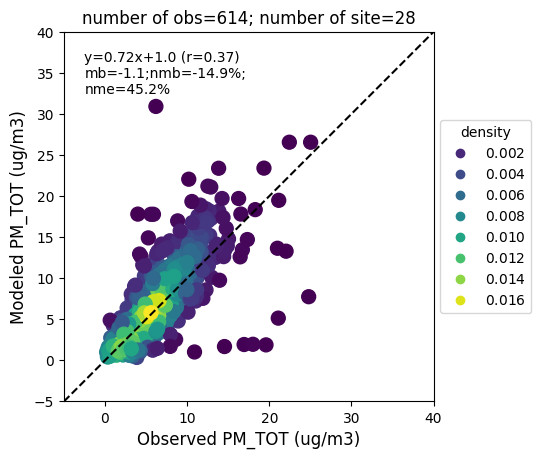

In [32]:
#density
TAQS = AQS_data.head(1000) #example test
TAQS = TAQS[TAQS['{}_ob'.format(pollutant)] != -999]
unit = "ug/m3"
densityplot(TAQS,pollutant,unit,statsdf)

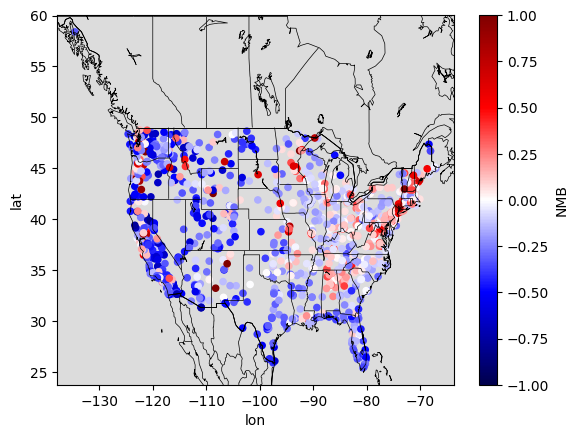

In [36]:
stat_map(stat_data,'NMB')

In [22]:
#time series
import matplotlib.dates as mdates
year = 2022
pollutant = "PM_TOT"
site = "AQS"
AQS_data_tmp_group = AQS_data_tmp.groupby(['Time On']).mean()
AQS_data_tmp_group['time'] = pd.to_datetime(AQS_data_tmp_group.index)
plt.plot(AQS_data_tmp_group['time'], AQS_data_tmp_group['{}_ob'.format(pol)], label = "obs")
plt.plot(AQS_data_tmp_group['time'], AQS_data_tmp_group['{}_mod'.format(pol)], label = "model")
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.xticks(rotation=90)
plt.ylim(top=25)
plt.ylim(bottom=0)
plt.legend()
#plt.show()
plt.title("CONUS")
plt.savefig(os.path.join(output_fig_timeseries_dir, '{}_{}_{}_model_performance.png'.format(year, pollutant, site)),bbox_inches='tight')
plt.close()

/tmp/ipykernel_1528869/84235162.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  AQS_data_tmp_group = AQS_data_tmp.groupby(['Time On']).mean()


In [23]:
states = AQS_data_tmp['State'].unique()
for state in states:
    AQS_data_tmp_state = AQS_data_tmp[AQS_data_tmp['State'] == state]
    AQS_data_tmp_state_group = AQS_data_tmp_state.groupby(['Time On']).mean()
    AQS_data_tmp_state_group['time'] = pd.to_datetime(AQS_data_tmp_state_group.index)
    plt.plot(AQS_data_tmp_state_group['time'], AQS_data_tmp_state_group['{}_ob'.format(pol)], label = "obs")
    plt.plot(AQS_data_tmp_state_group['time'], AQS_data_tmp_state_group['{}_mod'.format(pol)], label = "model")
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    plt.xticks(rotation=90)
    plt.ylim(top=25)
    plt.ylim(bottom=0)
    plt.legend()
    plt.title(state)
    #plt.show()
    plt.savefig(os.path.join(output_fig_timeseries_dir, '{}_{}_{}_{}_model_performance.png'.format(year, pollutant, site,state)),bbox_inches='tight')
    plt.close()

/tmp/ipykernel_1528869/315754497.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  AQS_data_tmp_state_group = AQS_data_tmp_state.groupby(['Time On']).mean()
/tmp/ipykernel_1528869/315754497.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  AQS_data_tmp_state_group = AQS_data_tmp_state.groupby(['Time On']).mean()
/tmp/ipykernel_1528869/315754497.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  AQS_data_tmp_state

In [28]:
#Kelly plots
region_state = {"Central":['Illinoi', 'Indiana', 'Kentucky','Missouri','Ohio','Tennessee','West Virginia'],
           "EN_Central":['Iowa','Michiga','Minnesota','Wisconsin'],
           "Northeast":['Connecticut','Delaware','MaineE','Maryland','Massachusetts','New Hampshire','New Jersey','New York','Pennsylvania','Rhode Island','Vermont'],
           "Northwest":['Idaho','Oregon','Washington'],
           "South":['AR','KS','LA','MS','OK','TX'],
           "Southeast":['AL','FL','GA','SC','NC','VA'],
           "Southwest":['AZ','CO','NM','UT'],
           "West":['CA','NV'],
           "WN_Central":['MT','NE','ND','SD','WY']}
region = ["Central","EN_Central","Northeast","Northwest","South","Southeast","Southwest","West","WN_Central"]
for r in region:
    


In [35]:
AQS_data_tmp['State'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District Of Columbia',
       'Florida', 'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
       'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Country Of Mexico'],
      dtype=object)